In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
#import sys
#sys.path.append('..')

from agrid.grid import Grid
from agrid.acc import download
from agrid.acc import names_to_depths

agrid 0.3.2


In [2]:
km = 1000
ant = Grid(crs=3031, res = [10*km, 10*km], 
           left = -3100*km, 
           up=3100*km, 
           right = 3100*km, 
           down = -3100*km)

In [3]:
url_raster = '''
    https://www.naturalearthdata.com/http//
    www.naturalearthdata.com/download/50m/
    raster/HYP_50M_SR_W.zip'''

raster_file = '../../data/ne/HYP_50M_SR_W/HYP_50M_SR_W.tif'

File ../../data/ne/HYP_50M_SR_W/HYP_50M_SR_W.tif already exists.


/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/agrid/grid.py:1148: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  epsg=basemap_epsg, **kwargs)


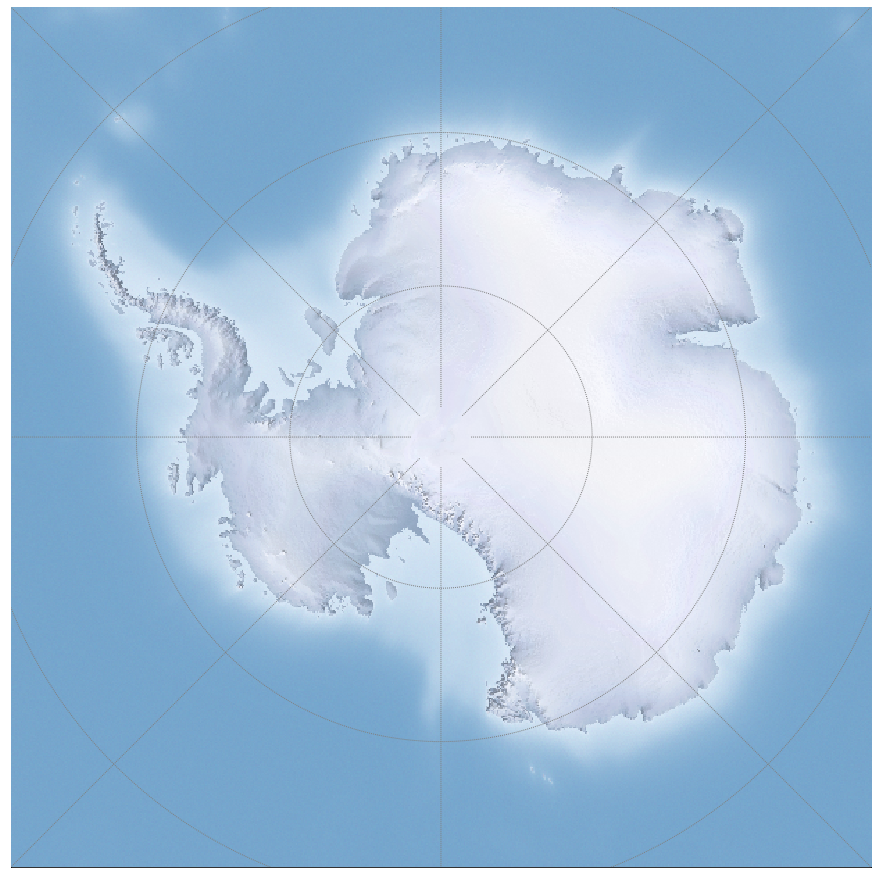

In [4]:
download(url_raster, raster_file)

ant.ds['RGB_RASTER'] = (('Y', 'X', 'RGB'), 
                ant.read_raster(raster_file,sub_sampling=3) )

ant.map_grid('RGB_RASTER', draw_coast=False)

In [12]:
vector_url = '''https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/physical/ne_10m_land.zip'''

vector_file = '../data/ne/ne_10m_land.zip'

download(vector_url, vector_file, 
        meta_dict={'Project' : 'Start using agrid', 'Dataset' : 'World vector'})

File ../data/ne/ne_10m_land.zip already exists.


['ne_10m_land.README.html',
 'ne_10m_land.VERSION.txt',
 'ne_10m_land.cpg',
 'ne_10m_land.dbf',
 'ne_10m_land.prj',
 'ne_10m_land.shp',
 'ne_10m_land.shx']

In [13]:
ant.ds['LAND'] = (('Y', 'X'), 
                ant.assign_shape('../data/ne/ne_10m_land.shp', 'scalerank', 
                                burn_val=1, map_to_int=False) )

/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/agrid/grid.py:1148: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  epsg=basemap_epsg, **kwargs)


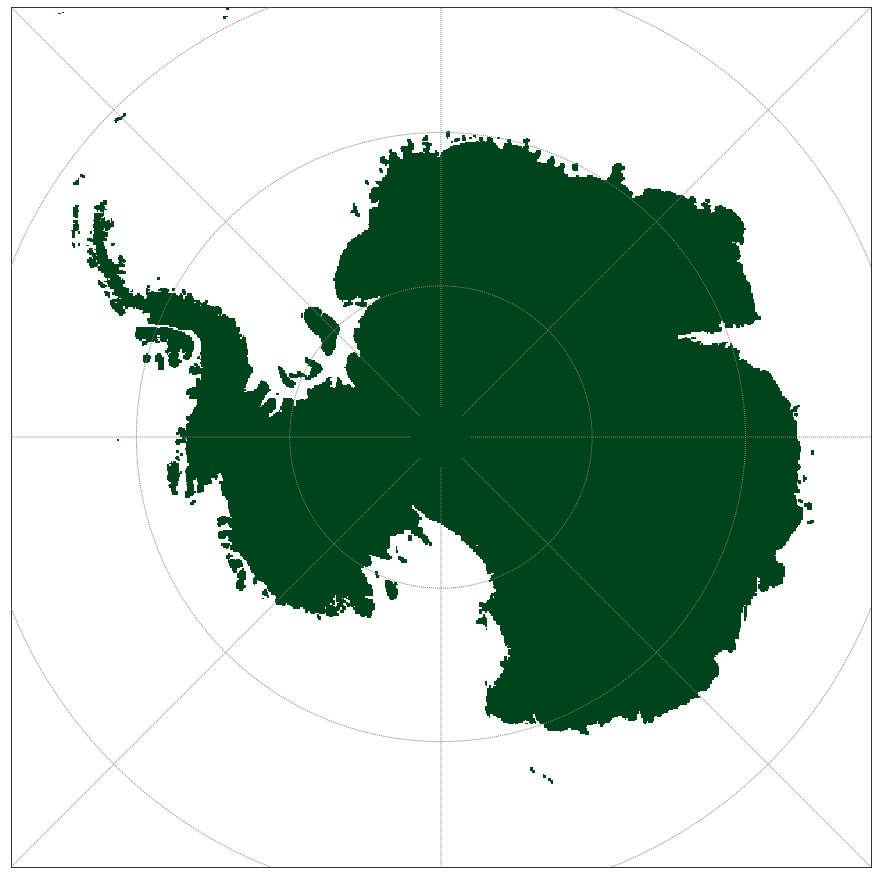

In [14]:
ant.map_grid('LAND', draw_coast=False, cmap='Greens_r')

In [15]:
arctic = Grid(crs=3995, res = [10*km, 10*km], 
           left = -3100*km, 
           up=3100*km, 
           right = 3100*km, 
           down = -3100*km)

In [ ]:
arctic.ds['LAND'] = (('Y', 'X'), 
                arctic.assign_shape('../data/ne/ne_10m_land.shp', 'scalerank', 
                                burn_val=1, map_to_int=False) )
arctic.map_grid('LAND', draw_coast=False, cmap='Greens_r')

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(arctic.ds['LAND'])

In [ ]:
arctic.ds['RGB_RASTER'] = (('Y', 'X', 'RGB'), 
                arctic.read_raster(raster_file,sub_sampling=1) )

arctic.map_grid('RGB_RASTER', draw_coast=True)

In [ ]:
depths_from_names('../../data/an/', format_type = float)

In [ ]:
depths = names_to_depths('../../data/an/')

In [ ]:
A = ant.read_grid('../../data/an/', xyz = ('x','y','z'), bulk=True, extension = '.grd', sort=True) 

In [ ]:
import numpy as np
np.shape(A)

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(A[...,13])

# Combine different resolutions

Sometimes, grids of different resolutions need to be joint. agrid includes a method to combine grids of different sizes, if the resolution is a multiple.

Consider this to model frames: 

In [7]:
world_course = Grid(crs=4326, res = [5, 5])
world_fine = Grid(crs=4326, res = [0.5, 0.5])

We populate them with some data: 

In [8]:
world_course.ds['LAND'] = (('Y', 'X'), 
                world_course.assign_shape('../data/ne/ne_10m_land.shp', 'scalerank', 
                                burn_val=1, map_to_int=False, all_touched=False) )
world_course.map_grid('LAND', figsize=(5,10))

world_fine.ds['RASTER'] = (('Y', 'X'), 
                world_fine.read_raster(raster_file,sub_sampling=3)[...,0] )
world_fine.map_grid('RASTER', figsize=(5,10))

DriverError: ../data/ne/ne_10m_land.shp: No such file or directory

Now we use the low res dataset to select blocks from the hi-res raster: 

In [ ]:
import numpy as np

small_raster = world_fine.fold_to_low_res(world_fine.ds['RASTER'], world_course.ds['LAND'])
print(np.shape(small_raster))

We generated a new dimension where blocks from the lare raster are converted ingto vectors. Now we can combin the two, e.g: 

In [ ]:
mostly_land_low_res = small_raster*world_course.ds['LAND'].values[:,:,None,None]

After the operations, we need to fold the hi-res array back to it's original shape:

In [ ]:
mostly_land_hi_res = world_fine.flatten_to_high_res(mostly_land_low_res, world_fine.ds['RASTER'])

In [ ]:
world_fine.map_grid(mostly_land_hi_res)

This functionallity will be further developed in subsequent versions. 

# Save RGB rasters

When saving RGB rasters, consider the data type and e.v. scaling. Set raster_factor and a different dtype (default is float). 

In [ ]:
world_course.ds['RASTER_RGB'] = (('Y', 'X', 'RGB'), 
                world_course.read_raster(raster_file,sub_sampling=10))
world_course.map_grid('RASTER_RGB')

In [ ]:
world_course.grid_to_raster('RASTER_RGB', raster_factor=255, raster_dtype = 'uint8')